# Example: Using the Flux Library to Learn Indifference Curves
The objective of this example is to demonstrate the construction, identification, and application of a [Feedforward Neural Network](https://en.wikipedia.org/wiki/Feedforward_neural_networkhttps://en.wikipedia.org/wiki/Feedforward_neural_network) for the simulation of `Cobb-Douglas` indifference curves. 

* We'll use the [Flux.jl](https://fluxml.ai) machine learning package (loaded by the `Include.jl` file) to build the neural network models and estimate the unknown parameter vector $\theta$.

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5760-Examples-F23`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Manifest.toml`


### Cobb-Douglas Utilty Functions 
The `Cobb-Douglas` utility function is the product of the $m$ feature variables, thus, 
it models situations where features occur simultaneously. Each feature variable is raised to a non-negative exponent:

$$
\begin{equation}
U(x_{1},\dots,x_{m}) = \prod_{i\in{1\dots{m}}}{x_{i}^{\alpha_{i}}}
\end{equation}
$$

In our realization of the `Cobb-Douglas` utility, the exponents must sum to unity $\sum_{i\in{1\dots{m}}}\alpha_{i} = 1$, $x_{i}\geq{0}$, and $\alpha_{i}\geq{0}$. 

#### Indifference
The set of indifferent choices for a given utility $U^{\star}$ for a `Cobb-Douglas` utility function is computed by solving the equation:

$$
\begin{equation}
\prod_{i\in{1\dots{m}}}{x_{i}^{\alpha_{i},\star}} - U^{\star} = 0
\end{equation}
$$

for the choices (or features) $x^{\star}_{1},\dots,x^{\star}_{m}$. We do this by creating a `VLCobbDouglasUtilityFunction` instance that holds the parameter vector $\alpha$, and then we use a `for` loop to iterate through a range of $U^{\star}$ values. During each pass of the loop, we:

* Setup the `lower` and `upper` bounds that are choice or feature variables are allowed to assume (we search this range for indifferent values)
* We compute the set of indifference set, by calling the `indifference(...)` method which is exported from the [VLDecisionsPackage.jl](https://github.com/varnerlab/VLDecisionsPackage.jl) package
* We plot the indifferent values using the `plot(...)` function which is exported from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package

In [2]:
Umax = [48.0, 36.0, 24.0, 12.0];
α = [0.55,0.45];
bounds = [
    1.0 100.0;
    1.0 1000.0;
];

Create a `VLCobbDouglasUtilityFunction` instance that holds the parameter vector $\alpha$ by calling the `build(...)` method:

In [3]:
model = build(VLCobbDouglasUtilityFunction, (
    α = α,    
));

Now, let's compute the indifference curve values for different utility levels `U`, for the `apples versus oranges` choice problem, and store them in the `cobb_douglas_simulation::Dict{Float64,Array{Float64,2}}` variable:

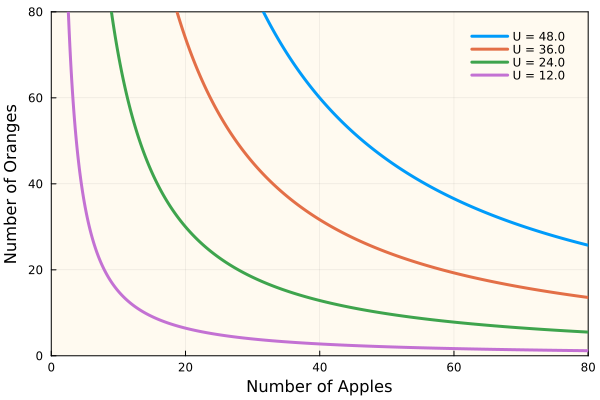

In [4]:
cobb_douglas_simulation = Dict{Float64,Array{Float64,2}}();
p = plot()
for U ∈ Umax

    # call -
    XCD = VLDecisionsPackage.indifference(model, utility=U, bounds=bounds, ϵ = 0.1);
    
    # capture the simulation data -
    cobb_douglas_simulation[U] = XCD;
    
    # plot -
    plot!(XCD[:,1],XCD[:,2],label="U = $(U)", lw=3, 
        bg="floralwhite", background_color_outside="white", framestyle = :box, fg_legend = :transparent, 
        ylims=(0.0,80.0), xlims=(0.0,80.0));
end
xlabel!("Number of Apples", fontsize=18)
ylabel!("Number of Oranges", fontsize=18)
current()

In [5]:
cobb_douglas_simulation[12.0]

990×2 Matrix{Float64}:
  1.05244  234.99
  1.15423  209.915
  1.25507  189.49
  1.35196  173.026
  1.45045  158.778
  1.55194  146.179
  1.64987  135.647
  1.75317  125.943
  1.84918  117.997
  1.9497   110.605
  2.04858  104.115
  2.15059   98.112
  2.24729   92.9772
  ⋮        
 98.8001     1.0
 98.9        1.0
 99.0001     1.0
 99.1        1.0
 99.2001     1.0
 99.3001     1.0
 99.4001     1.0
 99.5001     1.0
 99.6019     1.0
 99.7001     1.0
 99.8001     1.0
 99.9        1.0

## Let's learn the `U = 24` curve
First, let's specify which set of data we wish to learn in the `U` variable:

In [6]:
U = 24.0;

Next, we'll need to specify labeled training data that we can use to learn the unknown model parameters $\theta$. We'll sample the above simulation data, taking every `skip` number of points.
* `Note`: the data must be converted from a `Float64` to a `Float32` type. This is because most Machine Learning (ML) libraries, e.g., [TensorFlow](https://www.tensorflow.org), [PyTorch](https://pytorch.org) or [Flux.jl](https://fluxml.ai) are optimized for [GPU](https://developer.nvidia.com/deep-learning) support, where the default floating point data type is a `32-bit` float. 

In [7]:
# initialize storage for labeled data for training -
training_data = Vector{Tuple{Vector{Float32},Vector{Float32}}}()

# get simulation data -
simulation_data = cobb_douglas_simulation[U];

# build some samples -
skip = 20;
N = length(simulation_data[:,1]);
sample_range = 1:skip:N |> collect

apple_vector = convert.(Float32, simulation_data[sample_range, 1])
orange_vector = convert.(Float32, simulation_data[sample_range,2])
    
# make a training tuple -
training_tuple = (
    apple_vector, orange_vector
);
    
# insert -
push!(training_data, training_tuple);

In [8]:
apple_vector

50-element Vector{Float32}:
  1.05
  3.0502644
  5.051139
  7.051199
  9.054591
 11.050242
 13.050109
 15.050862
 17.050064
 19.053179
 21.050064
 23.050669
 25.05463
  ⋮
 77.050064
 79.05671
 81.05013
 83.049866
 85.0504
 87.063194
 89.0484
 91.049995
 93.06408
 95.06471
 97.05744
 99.049324

Now, we'll build a model to do the computation. In particular, since we have `length(sample_range)` inputs and outputs, we'll construct a `dense` network with `length(sample_range)`$\times$10 connected to a 10$\times$`length(sample_range)` output:

In [9]:
# build the model -
FFN_indifference_model = Chain(Dense(length(sample_range), 10, σ), Dense(10, length(sample_range)));

We'll use a loss function $L(\theta)$ of the form:

$$
L\left(\theta\right) = \frac{1}{n}\sum_{i\in\mathcal{D}}(\hat{y}_{i}\left(\theta\right) - y_{i})^2
$$

where $\hat{y}_{i}\left(\theta\right)$ denotes the estimated output, $y_{i}$ denotes the measured output, and $n$ denotes the number of training examples supplied to the network.

In [10]:
# setup a loss function -
loss(x, y) = Flux.Losses.mse(FFN_indifference_model(x), y; agg = mean)

loss (generic function with 1 method)

In [11]:
# pointer to params -
θ = Flux.params(FFN_indifference_model)

Params([Float32[-0.23042773 0.15219122 … -0.24668622 0.11281494; 0.08352614 0.053424858 … 0.048240352 -0.010423602; … ; 0.1869701 -0.006452494 … -0.30632675 -0.12685193; 0.2135661 0.21977915 … 0.015002314 -0.0634906], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.1216514 0.0019236548 … -0.040337905 -0.0071307058; 0.29633465 0.1437799 … -0.27144787 0.2989603; … ; 0.30931833 -0.07746355 … 0.15888068 -0.24182022; 0.15428802 -0.11826129 … -0.15500076 0.03963376], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [12]:
θ[4]

50-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Next, let's specify the optimization approach the we'll use to estimate the unknown model parameters $\theta$. In particular, we'll use the [Momentum gradient descent algorithm](https://optimization.cbe.cornell.edu/index.php?title=Momentum): 
> Momentum is an extension to the gradient descent optimization algorithm that allows the search to build inertia in a direction in the search space and overcome the oscillations of noisy gradients and coast across flat spots of the search space

In [13]:
λ = 0.1;  # learning rate
β = 0.95; # momentum parameter
opt = Momentum(λ, β);

We'll specify the number of times we process the data (called an `epoch`) in the `number_of_epochs` variable. To run the gradient descent estimation algorithm, we'll call the `train!(...)` function exported by the [Flux.jl](https://fluxml.ai) package:

In [14]:
number_of_epochs = 150;
for i = 1:number_of_epochs
    Flux.train!(loss, θ, training_data, opt)
end

Now that we have the updated model parameter vector $\theta$, we can run a forward prediction of the indifference curve by calling our model with an input vector. Let's store the predicted values in the `ŷ`  variable:

In [15]:
ŷ = FFN_indifference_model(apple_vector);

#### Visualize

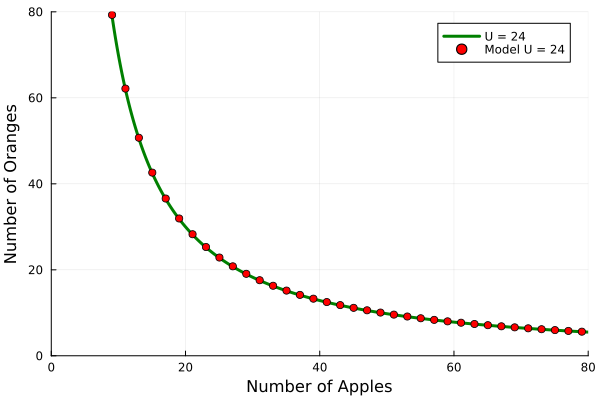

In [16]:
plot(simulation_data[:,1], simulation_data[:,2],lw=3,c=:green, 
    ylims=(0.0,80.0), xlims=(0.0,80.0), label="U = 24")
scatter!(apple_vector,ŷ, c=:red, label="Model U = 24")
xlabel!("Number of Apples", fontsize=18)
ylabel!("Number of Oranges", fontsize=18)

## OK, but can the model generalize?
The `ANN` model did pretty well learning the `U = 24` case after we increased the number of training epochs. But can we take that same model and have it simulate a different set of data, say the `U = 48` case? In other words, can the `ANN` generalize?

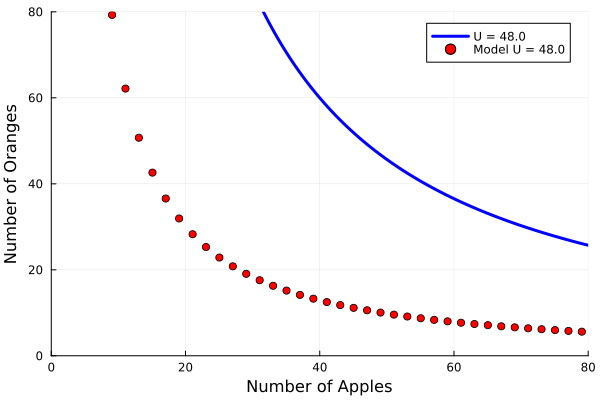

In [17]:
let
    # Let's test the model with a different U value
    U = 48.0;

    # get simulation data -
    simulation_data = cobb_douglas_simulation[U];

    # build some samples -
    skip = 20;
    N = length(simulation_data[:,1]);
    sample_range = 1:skip:N |> collect

    apple_vector = convert.(Float32, simulation_data[sample_range, 1])
    orange_vector = convert.(Float32, simulation_data[sample_range,2]);

    ŷ = FFN_indifference_model(apple_vector);

    plot(simulation_data[:,1], simulation_data[:,2],lw=3,c=:blue, 
        ylims=(0.0,80.0), xlims=(0.0,80.0), label="U = $(U)")
    scatter!(apple_vector,ŷ, c=:red, label="Model U = $(U)")
    xlabel!("Number of Apples", fontsize=18)
    ylabel!("Number of Oranges", fontsize=18)
end

## Hmmm. What happens if we make a family of models?

In [18]:
model_family_dict = Dict{Float64,Any}()
for U ∈ Umax
    
    # initialize storage for labeled data for training -
    training_data = Vector{Tuple{Vector{Float32},Vector{Float32}}}()

    # get simulation data -
    simulation_data = cobb_douglas_simulation[U];

    # build some samples -
    skip = 20;
    N = length(simulation_data[:,1]);
    sample_range = 1:skip:N |> collect

    apple_vector = convert.(Float32, simulation_data[sample_range, 1])
    orange_vector = convert.(Float32, simulation_data[sample_range,2])
    
    # make a training tuple -
    training_tuple = (
        apple_vector, orange_vector
    );
    
    # insert -
    push!(training_data, training_tuple);
    
    # build the model -
    FFN_indifference_model_local = Chain(Dense(50, 10, σ), Dense(10, 50));
    
    # setup a loss function -
    loss(x, y) = Flux.Losses.mse(FFN_indifference_model_local(x), y; agg = mean)
    
    # pointer to params -
    ps = Flux.params(FFN_indifference_model_local)
    
    # gradient descent -
    opt = Momentum(0.1, 0.95)
    
    number_of_epochs = 150;
    for i = 1:number_of_epochs
        Flux.train!(loss, ps, training_data, opt)
    end
    
    # store the model -
    model_family_dict[U] = FFN_indifference_model_local;
end

In [21]:
U_test = 24.0;
test_model = model_family_dict[U_test];
test_input = cobb_douglas_simulation[U_test][1:skip:end,1] .|> x-> convert(Float32,x);
ŷ_test = test_model(test_input);

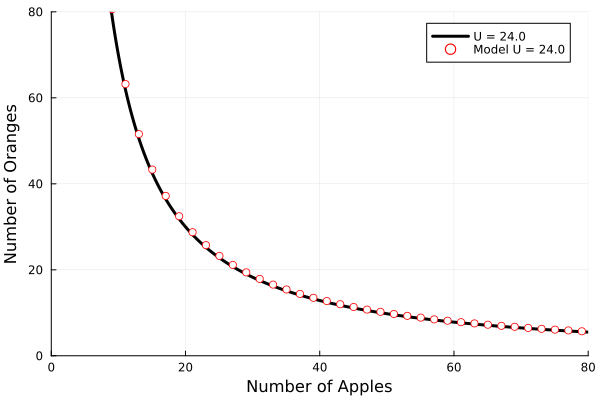

In [22]:
plot(cobb_douglas_simulation[U_test][:,1], 
    cobb_douglas_simulation[U_test][:,2], lw=3,c=:black, ylims=(0.0,80.0), xlims=(0.0,80.0), 
    label="U = $(U_test)")
scatter!(test_input,ŷ_test, c=:white, msc=:red, label="Model U = $(U_test)", ms=4)
xlabel!("Number of Apples", fontsize=18)
ylabel!("Number of Oranges", fontsize=18)